Early stopping en 130 árboles. Mejor accuracy CV: 0.8501 con 100 árboles.


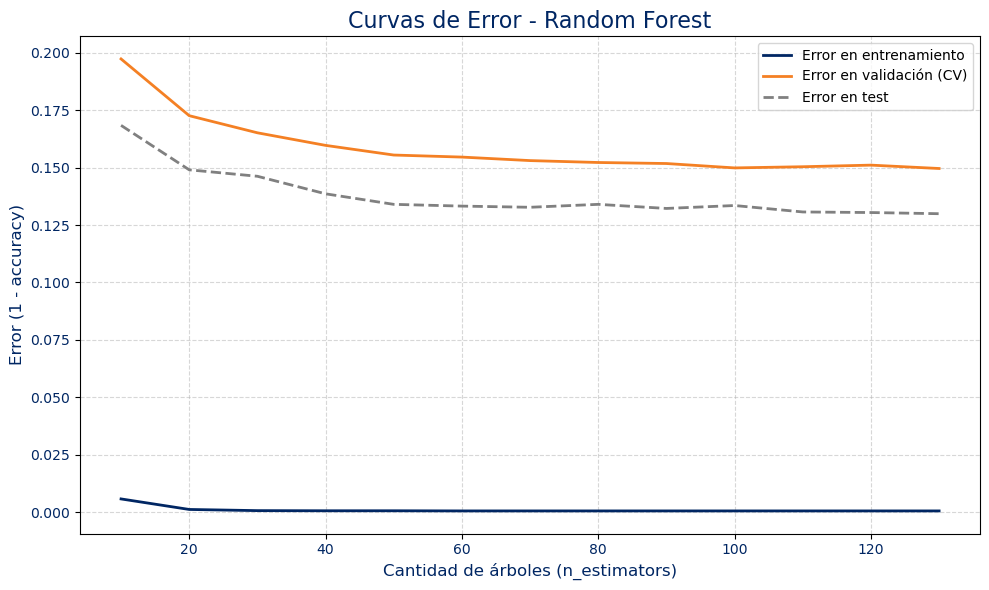

C:\Users\juang\AppData\Local\Temp\ipykernel_25392\3806089036.py:118: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  disp.plot(ax=ax, cmap=plt.cm.get_cmap('Oranges'), colorbar=False)


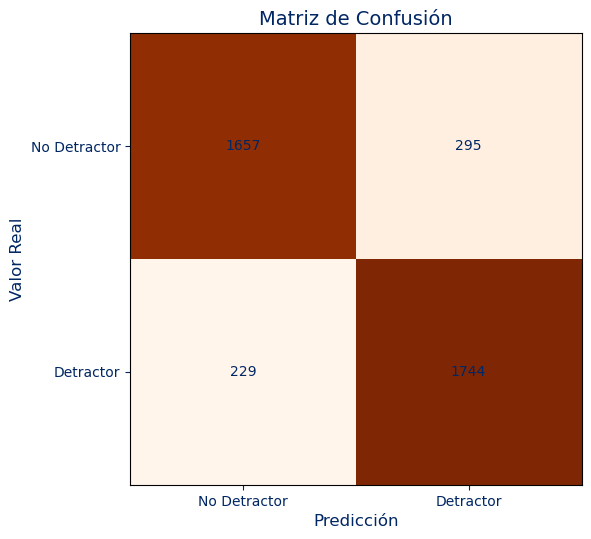


Reporte de clasificación:

              precision    recall  f1-score   support

No Detractor       0.88      0.85      0.86      1952
   Detractor       0.86      0.88      0.87      1973

    accuracy                           0.87      3925
   macro avg       0.87      0.87      0.87      3925
weighted avg       0.87      0.87      0.87      3925



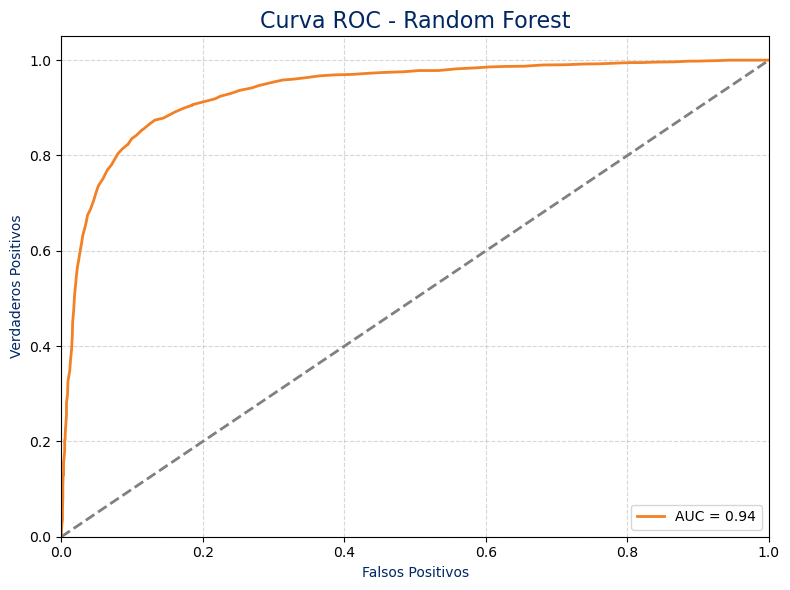

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
    classification_report
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # División del dataset
import matplotlib.pyplot as plt # Plotear
from sklearn.linear_model import LinearRegression # Modelo de ML
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix # Métricas
pd.options.display.max_columns= None
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold


df = pd.read_csv('base_final_PCA.csv', delimiter= ';')
x = df.drop(['detractor'], axis=1)
y = df['detractor']

#OverSampling:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
x_rf, y_rf = sm.fit_resample(x, y)


x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x_rf, y_rf,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

# --- Parámetros de early stopping ---
n_estimators_range = range(10, 510, 10)
patience = 3
tolerance = 0.001

# --- Almacenar resultados ---
train_errors = []
val_errors = []
test_errors = []

best_score = 0
best_n = 10
counter = 0

# --- Early stopping loop ---
for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=50)
    rf.fit(x_train_rf, y_train_rf)

    train_acc = rf.score(x_train_rf, y_train_rf)
    train_errors.append(1 - train_acc)

    val_acc = cross_val_score(rf, x_train_rf, y_train_rf, cv=5).mean()
    val_errors.append(1 - val_acc)

    test_acc = rf.score(x_test_rf, y_test_rf)
    test_errors.append(1 - test_acc)

    if val_acc > best_score + tolerance:
        best_score = val_acc
        best_n = n
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping en {n} árboles. Mejor accuracy CV: {best_score:.4f} con {best_n} árboles.")
        break

# --- Entrenar modelo final ---
rf_final = RandomForestClassifier(n_estimators=best_n, random_state=50)
rf_final.fit(x_train_rf, y_train_rf)
y_pred = rf_final.predict(x_test_rf)
y_prob = rf_final.predict_proba(x_test_rf)[:, 1]

# === GRÁFICO DE CURVAS DE ERROR ===
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range[:len(train_errors)], train_errors, label='Error en entrenamiento', color='#002663', linewidth=2)
plt.plot(n_estimators_range[:len(val_errors)], val_errors, label='Error en validación (CV)', color='#F48024', linewidth=2)
plt.plot(n_estimators_range[:len(test_errors)], test_errors, label='Error en test', color='gray', linestyle='--', linewidth=2)

plt.title('Curvas de Error - Random Forest', fontsize=16, color='#002663')
plt.xlabel('Cantidad de árboles (n_estimators)', fontsize=12, color='#002663')
plt.ylabel('Error (1 - accuracy)', fontsize=12, color='#002663')
plt.xticks(color='#002663')
plt.yticks(color='#002663')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_test_rf, y_pred)
labels = ['No Detractor', 'Detractor']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.get_cmap('Oranges'), colorbar=False)

plt.title("Matriz de Confusión", fontsize=14, color='#002663')
plt.xlabel("Predicción", fontsize=12)
plt.ylabel("Valor Real", fontsize=12)
for texts in [disp.text_]:
    for t in texts.flatten():
        t.set_color('#002663')
ax.xaxis.label.set_color('#002663')
ax.yaxis.label.set_color('#002663')
ax.tick_params(axis='x', colors='#002663')
ax.tick_params(axis='y', colors='#002663')
plt.tight_layout()
plt.show()

print("\nReporte de clasificación:\n")
print(classification_report(y_test_rf, y_pred, target_names=labels))

# === CURVA ROC ===
fpr, tpr, thresholds = roc_curve(y_test_rf, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#F48024', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos', color='#002663')
plt.ylabel('Verdaderos Positivos', color='#002663')
plt.title('Curva ROC - Random Forest', fontsize=16, color='#002663')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




# validamos clases en sub-sets
y_train_array = np.array(y_train_rf)
y_test_array = np.array(y_test_rf)

df_train = pd.DataFrame({'set': 'Entrenamiento', 'target': y_train_array})
df_test = pd.DataFrame({'set': 'Test', 'target': y_test_array})

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
folds_data = []

for fold_idx, (_, val_index) in enumerate(cv.split(x_train_rf, y_train_rf), 1):
    val_targets = y_train_array[val_index]
    df_val = pd.DataFrame({'set': f'Validación {fold_idx}', 'target': val_targets})
    folds_data.append(df_val)

df_all = pd.concat([df_train] + folds_data + [df_test], ignore_index=True)

df_all['target'] = df_all['target'].map({0: 'No Detractor', 1: 'Detractor'})

# Gráfico de proporciones con countplot
plt.figure(figsize=(12, 6))
sns.countplot(data=df_all, x='set', hue='target', palette=['#002663', '#F48024'], 
              hue_order=['No Detractor', 'Detractor'], stat="proportion")

plt.title('Distribución de Clases por Conjunto de Datos', fontsize=16, color='#002663')
plt.ylabel('Proporción', fontsize=12)
plt.xlabel('Conjunto', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()